**IMAGE CLASSIFICATION MODEL**

***Project Summary:***
> This project builds an image classification model using TensorFlow and Keras to classify images of food from the Food101 dataset. And EfficientNetB0 Model.



***Steps:***
1.   Data Loading and Preprocessing:
2.   Model Building
3.   Training
    * Feature Extraction Model
    * Fine Tuning
4.   Evaluating Results and Visualizing
5.   Predicting on a random image from test set


In [19]:
#downloading helper functions
!wget https://raw.githubusercontent.com/santhoshkumar510/Food-Classification/refs/heads/main/helperfunctions.ipynb?token=GHSAT0AAAAAADBM4B63JCJDNF2LULEF6P4IZ7KGYHQ
from helper_functions import create_tensorboard_callback, plot_loss_curves,compare_historys,load_and_prep_image


**Getting the data ready**

---


This involves loading the 101dataset from tensorflow library and preprocessing the data .
To understand the data worked on visualze the data ,this case plot random images and see

In [53]:
import tensorflow_datasets as tfds
(train_data,test_data),ds_info = tfds.load(name="food101",split=["train","validation"],shuffle_files=True,as_supervised=True,
                                             with_info=True)
class_names=ds_info.features["label"].names

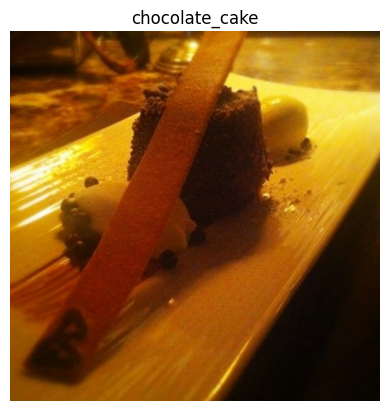

In [58]:
#view random picture along with its label
train_one_sample = train_data.take(1)
for img, lab in train_one_sample:
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.title(class_names[lab.numpy()])
  plt.axis(False);

In [59]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    #optional image=image/255.
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Test and Train Data split is done below

In [60]:
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating all checkpoint callbacks
We have a fn to create Tensorboard callback

In [61]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("checkpoint.weights.h5",monitor="val_accuracy",save_best_only=True,save_weights_only=True)


In [65]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

Creating Data Augmentation Layer

In [62]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

**Creating a feature Extraction Model**

---


base model is efficientnetb0 and mixed precision is used to make the training more faster and efficient.
And loss curve for this model is plotted.

In [63]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32)(x)
model=tf.keras.Model(inputs,outputs)
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
history=model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=int(0.15*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="logs",experiment_name="efficientnetb0_model"),model_checkpoint])

Saving TensorBoard log files to: logs/efficientnetb0_model/20250331-064629
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 83ms/step - accuracy: 0.4099 - loss: 2.5796 - val_accuracy: 0.6576 - val_loss: 1.2615
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 194s 81ms/step - accuracy: 0.5819 - loss: 1.6297 - val_accuracy: 0.6798 - val_loss: 1.1652
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 233s 95ms/step - accuracy: 0.6144 - loss: 1.4899 - val_accuracy: 0.7005 - val_loss: 1.1027
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 95ms/step - accuracy: 0.6359 - loss: 1.4111 - val_accuracy: 0.7063 - val_loss: 1.0722
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 230s 82ms/step - accuracy: 0.6461 - loss: 1.3571 - val_accuracy: 0.7071 - val_loss: 1.0645


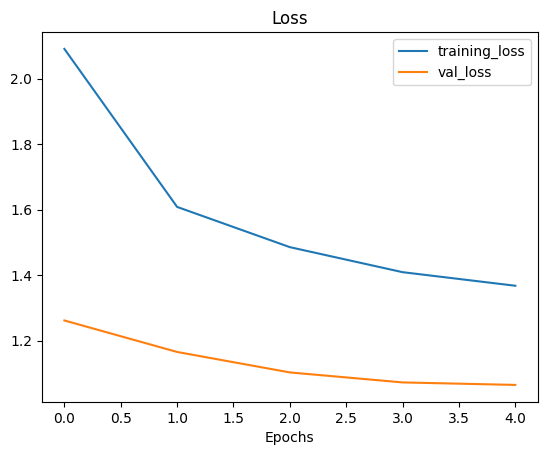

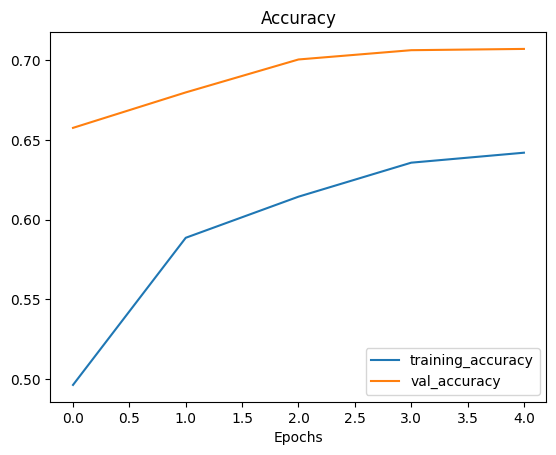

In [70]:
plot_loss_curves(history)

**Fine Tuning **

---

Unfreezing top 20 layers and fitting it with lower learning rate. And A callback to reduce lr if no improvement in accuracy.

In [66]:
base_model.trainable=True
for layers in base_model.layers[:-20]:
  layers.trainable=False
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy"])
history_2=model.fit(train_data,epochs=10,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=int(0.15*len(test_data)),initial_epoch=history.epoch[-1],callbacks=[create_tensorboard_callback(dir_name="logs8",experiment_name="efficientnetb0_model"),model_checkpoint,reduce_lr])

Saving TensorBoard log files to: logs8/efficientnetb0_model/20250331-070527
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 242s 94ms/step - accuracy: 0.5995 - loss: 1.5674 - val_accuracy: 0.7373 - val_loss: 0.9522 - learning_rate: 1.0000e-04
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 221s 93ms/step - accuracy: 0.6897 - loss: 1.1730 - val_accuracy: 0.7516 - val_loss: 0.8889 - learning_rate: 1.0000e-04
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 93ms/step - accuracy: 0.7173 - loss: 1.0649 - val_accuracy: 0.7564 - val_loss: 0.8589 - learning_rate: 1.0000e-04
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 94ms/step - accuracy: 0.7374 - loss: 0.9766 - val_accuracy: 0.7590 - val_loss: 0.8311 - learning_rate: 1.0000e-04
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 93ms/step - accuracy: 0.7498 - loss: 0.9211 - val_accuracy: 0.7664 - val_loss: 0.8120 - learning_rate: 1.0000e-04
Epoch 10/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 119ms/step - accuracy: 0.7662 - loss: 0.8598 - val_accuracy: 0.7667 - v

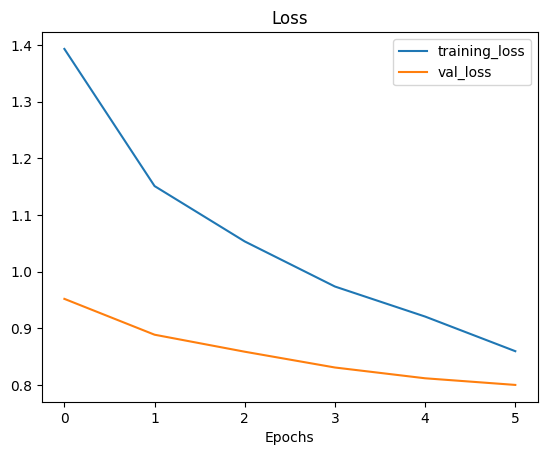

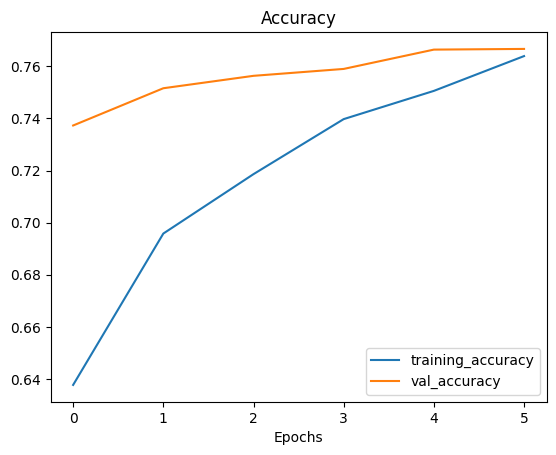

In [67]:
plot_loss_curves(history_2)

Comparing Feature Extraction Model with Fine Tuned Model

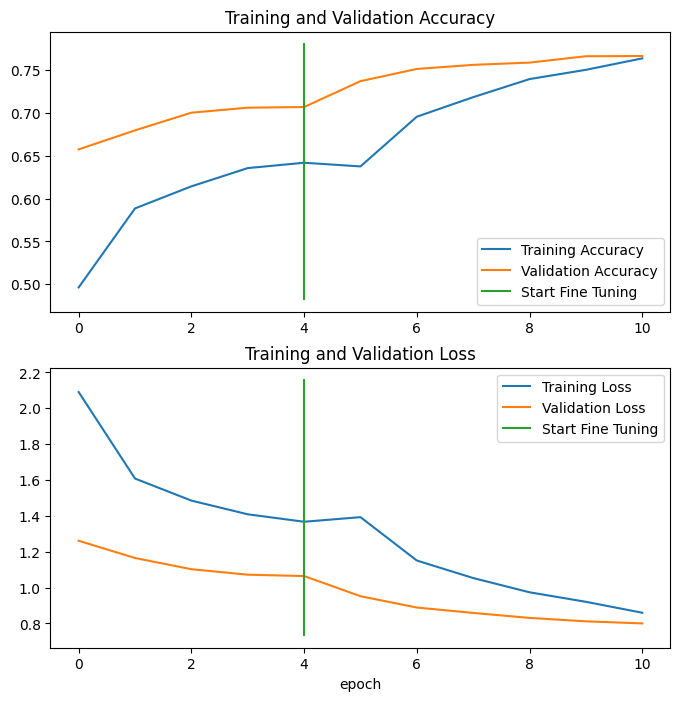

In [68]:
compare_historys(history,history_2)

**Evaluating the model's performance**


---
accuracy score,f1-score table , confusion matrix and predicting with random image.


In [69]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.7722 - loss: 0.8053


[0.8053640723228455, 0.7735445499420166]

In [87]:
pred_probs = model.predict(test_data, verbose=1)
pred_classes = pred_probs.argmax(axis=1)


790/790 ━━━━━━━━━━━━━━━━━━━━ 77s 97ms/step


In [82]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[np.int64(37),
 np.int64(99),
 np.int64(40),
 np.int64(60),
 np.int64(1),
 np.int64(69),
 np.int64(52),
 np.int64(62),
 np.int64(77),
 np.int64(67)]

In [83]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy


0.1531089108910891

In [84]:
from sklearn.metrics import classification_report
import pandas as pd
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
75,pho,0.244742
90,spaghetti_bolognese,0.220779
63,macarons,0.206478
33,edamame,0.205941
38,fish_and_chips,0.202783
...,...,...
60,lobster_bisque,0.106090
93,steak,0.100935
37,filet_mignon,0.099426
0,apple_pie,0.089286


In [85]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


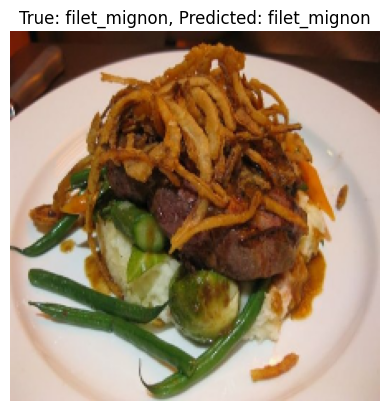

In [160]:
import matplotlib.pyplot as plt
import tensorflow as tf

image, label = next(iter(test_data.unbatch().take(1)))

prediction = model.predict(tf.expand_dims(image, axis=0))

predicted_class_index = prediction[0].argmax()

predicted_class_name = class_names[predicted_class_index]

plt.imshow(image.numpy().astype("uint8"))
plt.title(f"True: {class_names[label.numpy()]}, Predicted: {predicted_class_name}")
plt.axis(False)
plt.show()